In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics


### Ещё по теме классификации: AUC-ROC и AUC-PR

#### AUC-ROC

При конвертации вещественного ответа алгоритма в бинарную метку, мы должны выбрать какой-либо порог, при котором $0$ становится $1$. Естественным и близким кажется порог, равный $0.5$, но он не всегда оказывается оптимальным, например, при вышеупомянутом отсутствии баланса классов.


Одним из способов оценить модель в целом, не привязываясь к конкретному порогу, является AUC-ROC (или ROC AUC) — площадь (Area Under Curve) под кривой ошибок (Receiver Operating Characteristic curve ). Данная кривая представляет из себя линию от $(0,0)$ до $(1,1)$ в координатах True Positive Rate (TPR) и False Positive Rate (FPR):

$$\large TPR = \frac{TP}{TP + FN}$$
$$\large FPR = \frac{FP}{FP + TN}$$

TPR нам уже известна, это полнота, а FPR показывает, какую долю из объектов negative класса алгоритм предсказал неверно. В идеальном случае, когда классификатор не делает ошибок (FPR = $0$, TPR = $1$) мы получим площадь под кривой, равную единице; в противном случае, когда классификатор случайно выдает вероятности классов, AUC-ROC будет стремиться к $0.5$, так как классификатор будет выдавать одинаковое количество TP и FP.
Каждая точка на графике соответствует выбору некоторого порога. Площадь под кривой в данном случае показывает качество алгоритма (больше — лучше), кроме этого, важной является крутизна самой кривой — мы хотим максимизировать TPR, минимизируя FPR, а значит, наша кривая в идеале должна стремиться к точке ($0,1$).

In [2]:
df = pd.read_csv('prepared_data.csv')
df = df.dropna()
df['Sex'] = pd.factorize(df['Sex'])[0]
df['Embarked'] = pd.factorize(df['Embarked'])[0]
df['Name_Prefix'] = pd.factorize(df['Name_Prefix'])[0]
df['TicketPre'] = pd.factorize(df['TicketPre'])[0]
df['TicketNum_Groups'] = pd.factorize(df['TicketNum_Groups'])[0]
df['Lastname'] = pd.factorize(df['Lastname'])[0]
y = df['Survived']
df.drop(['Survived'], axis=1, inplace=True)
df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name_Prefix,Lastname,TicketPre,TicketNum_Groups,Relatives
0,3,0,22.0,1,0,7.2500,0,0,0,0,0,1
1,1,1,38.0,1,0,71.2833,1,1,1,1,1,1
2,3,1,26.0,0,0,7.9250,0,2,2,2,2,0
3,1,1,35.0,1,0,53.1000,0,1,3,3,3,1
4,3,0,35.0,0,0,8.0500,0,0,4,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,0,27.0,0,0,13.0000,0,5,664,3,440,0
887,1,1,19.0,0,0,30.0000,0,2,233,3,370,0
888,3,1,24.0,1,2,23.4500,0,2,604,11,417,3
889,1,0,26.0,0,0,30.0000,1,0,665,3,441,0


In [11]:
X_train, X_holdout, y_train, y_holdout = train_test_split(df.values, y, test_size=0.3, random_state=0)

tree = DecisionTreeClassifier(max_depth=5, random_state=0)
tree.fit(X_train, y_train)

tree_pred = tree.predict(X_holdout)

Важно понимать, что ROC-AUC и PR-AUC строятся **для каждого из классов** в задаче классификации

Пример кода, строящего графики ROC-AUC

predict_proba в качестве результата возвращает для каждой сущности предположение модели о вероятности принадлежности к тому или иному классу (в данном случае первый элемент из двух - предположение модели о том, что пассажир умрет, а второе число - о том, что выживет)

In [12]:
tree.predict_proba(X_holdout)[:5]

array([[0.88297872, 0.11702128],
       [0.3       , 0.7       ],
       [1.        , 0.        ],
       [0.02325581, 0.97674419],
       [0.25490196, 0.74509804]])

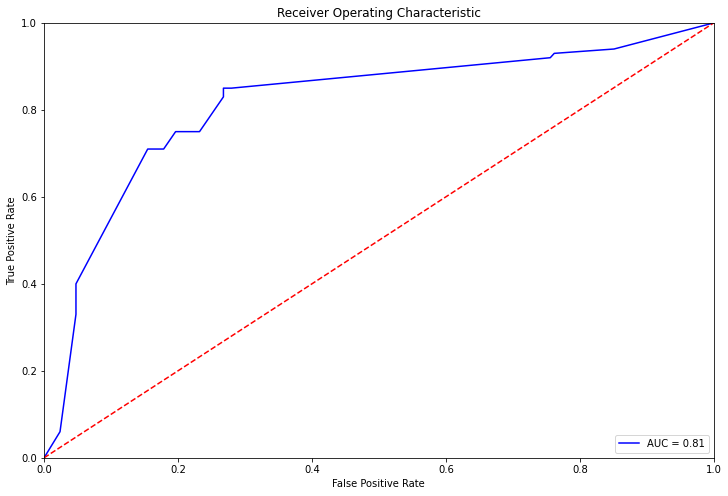

In [13]:
fpr, tpr, threshold = metrics.roc_curve(y_holdout, tree.predict_proba(X_holdout)[:, 1])
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')  
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Критерий AUC-ROC устойчив к несбалансированным классам (спойлер: увы, не всё так однозначно) и может быть интерпретирован как вероятность того, что случайно выбранный positive объект будет проранжирован классификатором выше (будет иметь более высокую вероятность быть positive), чем случайно выбранный negative объект.

#### PR-AUC

Аналогично графику ROC-AUC, мы можем построить график PR-AUC, где на осях вместо FPR и TPR будут располагаться Recall и Precision соответственно.

Логично, что это кривая, которая сочетает точность (её также называют PPV, то есть "positive predictive value") и полноту (TPR, то есть "true positive rate") в одной визуализации. Для каждого порога вы вычисляете значения PPV и TPR и строите их. Чем выше по оси Y ваша кривая, тем лучше производительность вашей модели.

Вы можете использовать этот график, чтобы принять взвешенное решение, когда дело доходит до классической дилеммы о том, что важнее для задачи: Precision или Recall. Очевидно, что чем выше Recall, тем ниже Precision. Знание того, при каком Recall ваша Precision начинает быстро падать, может помочь вам выбрать пороговое значение и создать лучшую модель.

Пороговое значение определяет, в какой момент модель следует прекратить обучать (то есть этот порог указывает на момент, в котором обученность модели оптимальна для решения задачи)

Пример кода, строящего график PR-AUC

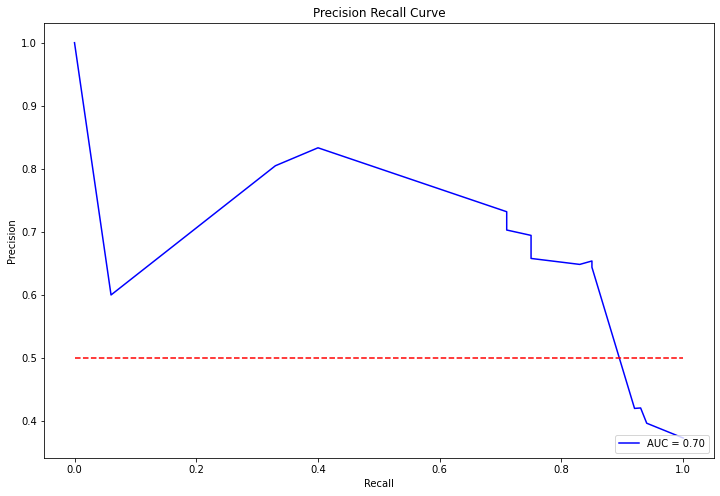

In [17]:
precision, recall, threshold = metrics.precision_recall_curve(y_holdout, tree.predict_proba(X_holdout)[:, 1])
pr_auc = metrics.auc(recall, precision)

plt.figure(figsize=(12, 8))
plt.title('Precision Recall Curve')
plt.plot(recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.plot([0, 1], [0.5, 0.5],'r--')  
plt.legend(loc = 'lower right')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#### Альтернативный способ построения графиков ROC-AUC и PR-AUC:

C:\Users\Иван\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Иван\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


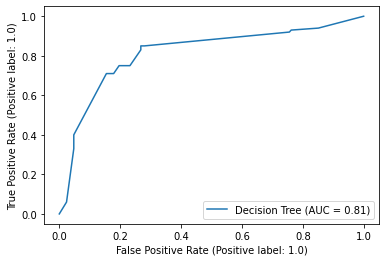

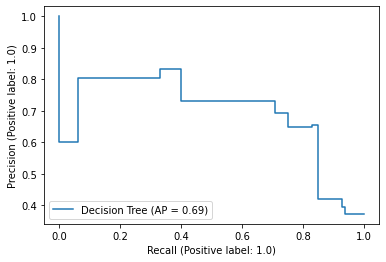

In [15]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve

plot_roc_curve(tree, X_holdout, y_holdout, name="Decision Tree")

plot_precision_recall_curve(tree, X_holdout, y_holdout, name = 'Decision Tree')

На последнем графике видно некоторое значение 

```AP = 0.74```

AP (Average Precision) суммирует кривую Precision-Recall как средневзвешенное значение Precision, достигнутой при каждом пороговом значении, с увеличением Recall по сравнению с предыдущим пороговым значением, используемым в качестве веса.

Кроме того, можно заменить, что только что построенный график PR-Curve отличается от того, которого мы строили вручную с помощью matplotlib. Это произошло потому, что для построения первого графика было взято небольшое количество координат точек, от того картина является менее четкой. Также не было осуществлено некоторой пост обработки графика, но, тем не менее, полезность графика не была потеряна.

Каждый из способов построения графика является по-своему полезным.

## Встречайте новый класс задач: регрессия!

Рассказ про линейные модели мы начнем с линейной регрессии. В первую очередь, необходимо задать модель зависимости объясняемой переменной $y$ от объясняющих ее факторов, функция зависимости будет линейной:

$$y = w_0 + \sum_{i=1}^m w_i x_i$$

Если мы добавим фиктивную размерность $x_0 = 1$ для каждого наблюдения, тогда линейную форму можно переписать чуть более компактно, записав свободный член $w_0$ под сумму:

$$y = \sum_{i=0}^m w_i x_i = \vec{w}^T \vec{x}$$

Если рассматривать матрицу наблюдения-признаки, у которой в строках находятся примеры из набора данных, то нам необходимо добавить единичную колонку слева. Зададим модель следующим образом:

$$\large \vec y = X \vec w + \epsilon,$$

где
* $\vec y \in \mathbb{R}^n$ – объясняемая (или целевая) переменная;
* $w$ – вектор параметров модели (в машинном обучении эти параметры часто называют весами);
* $X$ – матрица наблюдений и признаков размерности $n$ строк на $m + 1$ столбцов (включая фиктивную единичную колонку слева) с полным рангом по столбцам: $\text{rank}\left(X\right) = m + 1$;
* $\epsilon$ – случайная переменная, соответствующая случайной, непрогнозируемой ошибке модели (нормальный шум).

### Так, формулы, окей... а че такое регрессия-то в итоге?

Если утрировать, то задача регрессии – прогноз на основе выборки объектов с различными признаками. На выходе должно получиться вещественное число (2, 35, 76.454 и др.), к примеру цена квартиры, стоимость ценной бумаги по прошествии полугода, ожидаемый доход магазина на следующий месяц, качество вина при слепом тестировании.

Давайте поподробнее разберем загадочную переменную $w$. На самом деле это просто вес того или иного признака, влияющий на прогноз. Рассмотрим простой пример с прогнозированием цены на квартиру. Очевидно, что такие признаки как, например, количество комнат, расположение квартиры в том или ином районе и общее состояние квартиры (сделан ли там ремонт или это столетняя хрущевка, которую ремонтировали 10 лет назад) будут играть важную роль для продавца для выставления цены за нее, следовательно и веса у этих признаков будут выше, чем у, например, номера телефона владельца, количества окон или дверей и подобных, которые обычно никак не учитываются при продаже квартиры. Следовательно, и для модели эти признаки не очень важны.

Таким образом, задача регрессии - это задача нахождения правильных весов $w$ для некоторой функции, которые максимально близко смогут описать реальную важность того или иного признака при прогнозирования вещественнозначного целевого атрибута.

### Деревья решений в задаче регрессии

Как ни странно, но наши недавние знакомые в лице kNN и деревьев решений тоже вполне способны решать задачи регрессии, пускай и с некоторыми особенностями, отличными от своих сородичей-классификаторов. Рассмотрим, в частности, деревья решений:

При прогнозировании количественного признака идея построения дерева остается та же, но меняется критерий качества - **дисперсия вокруг среднего**:

$$\Large D = \frac{1}{\ell} \sum\limits_{i =1}^{\ell} (y_i - \frac{1}{\ell} \sum\limits_{i =1}^{\ell} y_i)^2, $$
где $\ell$ – число объектов в выборке, $y_i$ – значения целевого признака. Попросту говоря, минимизируя дисперсию вокруг среднего, мы ищем признаки, разбивающие выборку таким образом, что значения целевого признака в каждом листе примерно равны.

Ниже приведен искусственносозданный игрушечный пример, который вам в той или иной мере поможет примерно понять концепцию решения задачи регрессии с помощью дерева решений. Ради интереса можно поиграться с гиперпараметрами и функцией, значения которой должен угадывать регрессор.

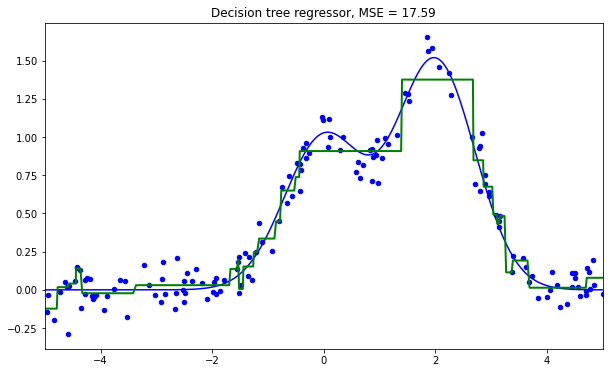

In [4]:
# задаем размеры выборок и параметр шума
n_train = 150        
n_test = 1000       
noise = 0.1

# ниже идут функции, одну из которых можно выбрать для того,
# чтобы модель-регрессор пыталась её угадать
def f(x):
    x = x.flatten()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def sin_f(x):
    x = x.flatten()
    return np.sin(x)

# две функции генерации обучающей и тестовой выборки, содержимое которых:
# взять функцию f или sin_f, добавить к ней шум
# определить параметр 'X' как обычную переменную, а значение 'y' - как целевую

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).flatten()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
    np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

def sin_generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).flatten()
    y = np.sin(X) + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

# определяем модель
reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

# X_train, y_train = sin_generate(n_samples=n_train, noise=noise)
# X_test, y_test = sin_generate(n_samples=n_test, noise=noise)

# генерируем выборки с помощью функций
X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

# обучаем модель, осуществляем предсказание
reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

# рисуем полученный результат:
# синяя линия - тестовая выборка
# синие точки - обучающая выборка
# зеленая линия - предсказания модели

plt.figure(figsize=(10, 6))
# plt.plot(X_test, sin_f(X_test), "b")
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()

### Оценки качества модели в задачах регрессии

В примере ранее (на рисунке в частности) было написано некоторое число 'MSE'. Возможно кто-то уже догадался, что это - одна из метрик качества модели-регрессора. Не трудно понять, что классификационные метрики не валидны для задач регрессии, банально потому, что (условно) предсказание модели, равное 1.2, не будет равно тестовому ответу, равному 1.3, и в итоге ответ модели по метрике для классификаторов будет считаться ошибочным, что не совсем корректно. Для задач регрессии есть специальные метрики оценки качества, своим значением показывающие, насколько сильно предположение модели отлично от реального ответа.

Существуют две основные метрики, которые описывают качество работы регрессионой модели, на основе которых строятся еще много других более понятных человеку метрик.

Давайте попробуем самый наивный способ измерения качества, который сразу приходит на ум. Будем просто вычитать из правильных ответов неправильные, суммировать результат, а после поделим на количество объектов, которые мы рассмотрели, т.е.:

$$\frac{1}{n}\sum\limits_{i=1}^n y_i - y_{pred}$$

Тут мы сталкиваемся с проблемой: предсказанные значения могут быть как больше истинных, так и меньше, из-за чего при отрицательных значениях разности ошибка будет уменьшаться (что некорректно). Очевидно, что существует два способа, как это избежать, и эти два способа формируют две важные метрики.

Первый способ представляет собой взятие квадрата разности. Такая метрика называется средней квадратичной ошибкой (Mean Square Error, MSE).

$$MSE = \frac{1}{n}\sum\limits_{i=1}^n (y_i - y_{pred})^2$$

Второй способ - это взятие модуля разности. Такая метрика называется средней абсолютной ошибкой (Mean Absolute Error, MAE).

$$MAE = \frac{1}{n}\sum\limits_{i=1}^n |y_i - y_{pred}|$$

Обе метрики хороши, но каждая имеет свой существенный минус. MSE - очень неустойчива к выбросам, потому что даже одно большое значение в квадрате даст огромный прирост к ошибке. Проблема с MAE не слишком очевидна. По сути, в DS и ML всё обучение модели строится на минимизации функции потерь (будь то MSE или MAE) путем взятия дифференциала, а, как мы помним из курса математического анализа, в очень маленьких значениях, стремящихся к 0, модуль не дифференцируем, что затрудняет минимизацию.

### Другие метрики

Вышеописанные метрики очень хороши для машины, но имеют проблемы для восприятия человеком. Вернемся к задаче анализа цены на квартиру (то есть целевой признак - стоимость квартиры в рублях). Вы обучили модель, она показала хороший результат MSE (ошибка всего 1000000 $р^2$). Вы приносите результат заказчику, который ничего не понимает в ML и DS. Первый вопрос, который у него возникнет - что такое квадратные рубли? Это какая-то новая валюта в странах третьего мира? Второй - почему ошибка такая большая? Очевидно, что это будет большое фиаско для вас и компании, которое в лучшем случае закончится потерей вами части ЗП, а в худшем - увольнением. Заказчик уйдет, так и не узнав, что в среднем модель ошибается на 1000 рублей, что для такой задачи некритично. Чтобы этого избежать, достаточно было просто взять корень из результата, таким образом приведя квадратные рубли к обычным. Умные люди даже дали название этой метрике: RMSE (Root Mean Square Error):

$$RMSE = \sqrt{\frac{1}{n}\sum\limits_{i=1}^n (y_i - y_{pred})^2}$$

Для задачи с прогнозированием цены на недвижимость легко понять, хорошее ли значение метрики или нет, просто взглянув на нее. Но не для всех задач это очевидно. В этом случае надо либо хорошо разбираться в области, на которой основана задача, или иметь постоянную связь с клиентом или человеком, который в ней разбирается. Вот бы было все просто как в классификации: чем больше десятичная дробь, тем лучше... Такая метрика тоже есть, ее называют $R^2-score$ или ошибкой детерминации. Она показывает, насколько сильно полученная MSE отличается от дисперсии выборки.

$$R^2 = 1 - \frac{MSE}{Var(Y)}$$

Очевидно, что чем лучше работает наша модель, тем ее MSE будет меньше дисперсии. То есть коэффициент детерминации позволяет оценить предсказание модели.

### МНК

Как уже упоминалось выше, обучение модели построено на минимизации функции потерь. Существует несколько способов это сделать. Самый точный способ найти веса модели, которые лучше всего опишут выборку в статистике, называется МНК. Его идея заключается в том, чтобы приравнять дифференциал функции потерь к 0, выразить вектор весов как неизвестную переменную в уравнении, и решить полученное уравнение. Конкретно для MSE это будет иметь следующий вид:

$$\frac{\delta L}{\delta\vec w} = \frac {1} {2n} (-2X^T\vec y + 2X^TX\vec w) = 0$$

$$-X^T\vec y + X^TX\vec w = 0$$

$$X^TX\vec w = X^T\vec y$$

$$\vec w = (X^TX)^{-1}X^T\vec y$$

Однако этот способ носит на себе проклятие больших данных: построение обратной матрицы является очень дорогой по времени операцией. Поэтому данный способ не используется на практике для обучения модели, но прекрасно подходит для примерного понимания процесса обучения.

### Пример построения модели для регрессии

Ниже будет приведен ещё один пример задачи регрессии, где мы будем иметь один обычный признак и один целевой.

In [2]:
# считываем данные
df = pd.read_csv("test.csv")

In [3]:
df

,x,y
0,77,79.775152
1,21,23.177279
2,22,25.609262
3,20,17.857388
4,36,41.849864
...,...,...
295,71,68.545888
296,46,47.334876
297,55,54.090637
298,62,63.297171


D:\JN\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

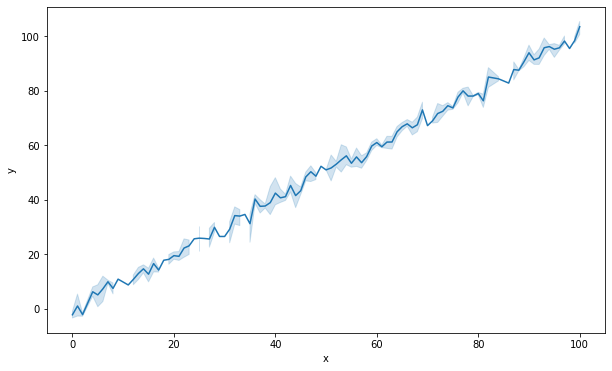

In [4]:
# смотрим на данные, преисполняемся решимостью
plt.figure(figsize=(10, 6))
sns.lineplot(df['x'], df['y'])

Определяем модель

In [5]:
reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

Осуществляем разделение данных на обучающую и тестовую выборку в соотношении 7/3

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df['x'], df['y'], test_size=0.3, shuffle=False)

Обучаем модель на трейновой выборке и получаем предсказания модели на тестовой

P.S. ```values.reshape(-1, 1)``` осуществляется потому, что в данном примере имеется только один признак. Если не применять этот метод, sklearn будет просто напросто выдавать ошибку

In [7]:
reg_tree.fit(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))
reg_tree_pred = reg_tree.predict(X_test.values.reshape(-1, 1))

In [8]:
reg_tree_pred

array([ 22.85368576,  47.28665038,  58.00935178,  47.28665038,
        22.85368576,  53.87917452,  53.87917452,  97.10992642,
        10.60273157,   5.78854623,  10.60273157, 105.5918375 ,
        51.23963351,  41.25868609,  97.10992642,  41.25868609,
       105.5918375 ,  87.52313489,  13.27039526,  13.27039526,
        38.46679572,  10.60273157,  87.52313489,  92.89394584,
        67.83223553,  73.88892659,  53.87917452,  18.25887333,
        10.60273157,  29.01976114,  92.89394584,  47.28665038,
        53.87917452,  41.25868609,  47.28665038,  33.55143727,
        67.83223553,  87.52313489,  92.89394584,  38.46679572,
        18.25887333,  97.10992642,  53.87917452,  60.71336934,
        67.83223553,  78.26140384,  90.24952781,  10.60273157,
        67.83223553,  38.46679572,  18.25887333, 105.5918375 ,
        47.28665038,  73.88892659,  53.87917452,  18.25887333,
        78.26140384,  33.55143727,  53.87917452,  71.00062237,
        53.87917452,  10.60273157,  53.87917452,  71.00

Рисуем полученные предсказания (красные) вместе с тестовыми значениями (зеленые)

D:\JN\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\JN\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

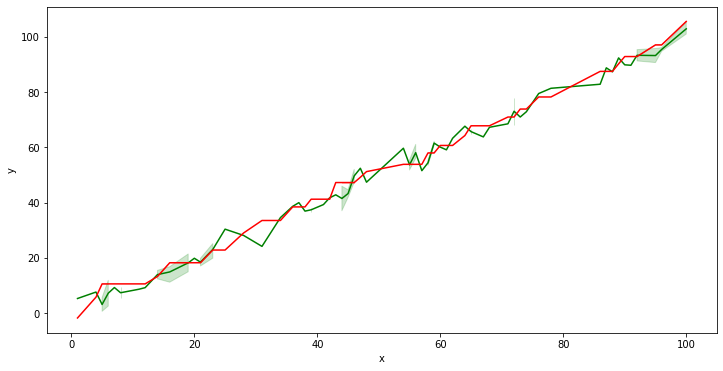

In [9]:
plt.figure(figsize=(12, 6))
sns.lineplot(X_test, y_test, color='g')
sns.lineplot(X_test, reg_tree_pred, color='r')

Не ленимся осуществить подсчет MSE вручную

In [10]:
mse = sum((y_test - reg_tree_pred)**2) / y_test.shape[0]
print("MSE: ", mse)

MSE:  13.85068529386818


С регрессионными моделями, так же как и с моделями-классификаторами, можно осуществлять тюнинг гиперпараметров (в том числе и нам знакомыми средствами - GridSearchCV)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best params:  {'max_depth': 5}


D:\JN\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\JN\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\JN\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

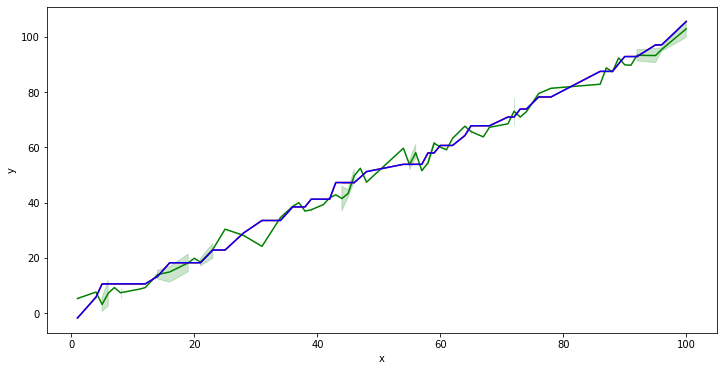

In [11]:
tree_params = {'max_depth': range(1,11)}

tree_grid = GridSearchCV(reg_tree, tree_params,
                         cv=5, n_jobs=-1,
                         verbose=True)

tree_grid.fit(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))

print("best params: ", tree_grid.best_params_)

tree_grid_pred = tree_grid.predict(X_test.values.reshape(-1, 1))

plt.figure(figsize=(12, 6))
sns.lineplot(X_test, y_test, color='g')
sns.lineplot(X_test, tree_grid_pred, color='r')
sns.lineplot(X_test, reg_tree_pred, color='b')